In [17]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
import os
import resampy

In [18]:
def load_data(data_path):
    data = []
    labels = []
    emotions = {'angry_05': 0,  'disgust_07': 1, 'fearful_06': 2, 'happy_03': 3, 'neutral_01': 4, 'sad_04': 5, 'suprised_08': 6} # Duygulara göre etiketler
    for emotion in emotions.keys():
        emotion_path = os.path.join(data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith('.wav'):
                filepath = os.path.join(emotion_path, filename)
                feature = extract_feature(filepath)
                data.append(feature)
                labels.append(emotions[emotion])
    return np.array(data), np.array(labels)

In [19]:
def extract_feature(file_path, n_mfcc=40, max_len=174):
    audio_data, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    pad_width = max_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    #print(mfccs)
    return mfccs

In [26]:
data, labels = load_data('D:/yapayzekafinal/ses')
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [27]:
from keras.utils import to_categorical
print(y_train)
y_train_encoded = to_categorical(y_train, num_classes=7)
y_test_encoded = to_categorical(y_test, num_classes=7)
print(y_train_encoded)


[3 0 1 ... 3 3 2]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [28]:
x_train.shape

(1660, 40, 174)

In [29]:
cnn_model = Sequential()

# Convolutional ve MaxPooling katmanları
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(40, 174, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='sigmoid'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# Tam bağlantılı (fully connected) katmanlar
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='sigmoid'))

# Çıkış katmanı
cnn_model.add(Dense(7, activation='softmax'))  # 10 sınıf için çıkış

In [30]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
cnn_history = cnn_model.fit(x_train, y_train_encoded, batch_size=64, epochs=20, validation_data=(x_test, y_test_encoded))


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.1579 - loss: 2.0014 - val_accuracy: 0.1783 - val_loss: 1.9074
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.1775 - loss: 1.9058 - val_accuracy: 0.1880 - val_loss: 1.8548
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.2500 - loss: 1.8259 - val_accuracy: 0.2434 - val_loss: 1.8014
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.2775 - loss: 1.7497 - val_accuracy: 0.3229 - val_loss: 1.7199
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.3670 - loss: 1.6519 - val_accuracy: 0.3325 - val_loss: 1.6380
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 327ms/step - accuracy: 0.4484 - loss: 1.5275 - val_accuracy: 0.4217 - val_loss: 1.5420
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step - accuracy: 0.5116 - loss: 1.4151 - val_accuracy: 0.4843 - val_loss: 1.3917
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.5770 - loss: 1.2711 - val_accuracy: 0

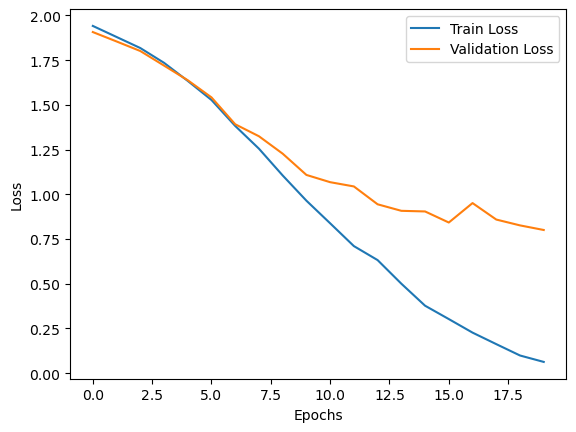

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
cnn_scores = cnn_model.evaluate(x_test, y_test_encoded, verbose=0)
print("CNN Model Accuracy: %.2f%%" % (cnn_scores[1]*100))

CNN Model Accuracy: 72.53%


In [34]:
cnn_y_pred = cnn_model.predict(x_test)
cnn_y_pred_labels = np.argmax(cnn_y_pred, axis=1)
print(classification_report(y_test, cnn_y_pred_labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
              precision    recall  f1-score   support

           0       0.70      0.92      0.80        76
           1       0.67      0.70      0.68        40
           2       0.67      0.66      0.66        76
           3       0.82      0.62      0.71        74
           4       0.81      0.78      0.79        37
           5       0.77      0.68      0.72        72
           6       0.69      0.72      0.71        40

    accuracy                           0.73       415
   macro avg       0.73      0.73      0.72       415
weighted avg       0.73      0.73      0.72       415



In [35]:
cnn_model.save('sesmodeli2.keras')